# Decision Trees

This is an exercise in writing a decision tree from scratch. In this case, it will mean only using `numpy`. The second part will also show the same example in a more "conventional" python package. 

The purpose of this toy example will be to predict whether a politician is a democrat or republican based on past voting history. 

In [2]:
import csv
import numpy as np

### 1) Write a decision tree from scratch

In [3]:
datafolder = 'data/decision_trees/'
infiletrain = 'politicians_train.tsv'
infiletest = 'politicians_test.tsv'
maxdepth = 3
outfiletrain = 'pol_3_train.labels'
outfiletest = 'pol_3_test.labels'
metricsout = 'pol_3_metrics.txt'

In [4]:
# import given input file
def importdata(filename):
    data = []
    with open(filename) as tsvfile:
        reader = csv.reader(tsvfile, delimiter="\t")
        for row in reader:
            data.append(row)
    return data

# Import input data 
datain = np.array(importdata(datafolder+infiletrain))
attributeNames = datain[0].tolist()[0:-1]
datain = datain[1:len(datain),:].tolist()

# check the format
print("Attribute names are %s." %(attributeNames))
attributes = len(attributeNames)
print('Total number of attributes: %d' %(attributes))
print('Example list item: '+ str(datain[0]))

Attribute names are ['Anti_satellite_test_ban', ' Aid_to_nicaraguan_contras', ' Mx_missile', ' Immigration', ' Superfund_right_to_sue', ' Duty_free_exports', ' Export_south_africa'].
Total number of attributes: 7
Example list item: ['n', 'n', 'n', 'y', 'y', 'y', 'y', 'democrat']


In [5]:
# define two categories (labels)
label0 = datain[0][-1]
for n in range(0,len(datain)):
    if datain[n][-1] != label0:
        label1 = datain[n][-1]
        break

print("Two labels are %s and %s." %(label0,label1))

Two labels are democrat and republican.


In [6]:
# define binary vote categories (votes)
vote0 = datain[0][-2]
for n in range(0,len(datain)):
    if datain[n][-2] != vote0:
        vote1 = datain[n][-2]
        break

print("Binary vote categories are %s and %s." %(vote0,vote1))

Binary vote categories are y and n.


First define the tree node structure. Some parameters that need to be tracked: depth, location in the tree, the split attribute, criteria for splitting (gini impurity), and whether we've reached a leaf

In [7]:
# tree structure definition
class Node:
    def __init__(self,dataAll,depth,keys):
        self.dataNode = dataAll
        self.depth = depth
        self.dataLeft = None
        self.dataRight = None
        self.splitAttr = None
        self.keysAttr = keys
        self.giniImpurity = None
        self.nodeLeft = None
        self.nodeRight = None
        self.leaf = None
        self.leafLabel = None

Count the majority of the votes for a given set of items

In [8]:
# count votes for given data set (assume no heading in data set)
def majvote(data):
    count0 = 0
    count1 = 0
    for n in range(0,len(data)):
        if data[n] == label0:
            count0 += 1
    count1 = len(data)-count0
    return count0,count1

Determine the criteria, or metric, of the split. This example uses Gini Impurity, though others are possible. 

In [9]:
# get gini impurity for data set
def giniImpurity(data):
    count0,count1 = majvote(data)
    #print('Counts are: %d and %d'%(count0,count1))
    counttotal = count0+count1
    Prob0 = count0/counttotal
    Prob1 = count1/counttotal
    GiniImp = Prob0*(1-Prob0) + Prob1*(1-Prob1)
    return GiniImp

# calculate gini gain of possible split
def giniGain(leftBranch,rightBranch):
    dataL = [item[-1] for item in leftBranch]
    dataR = [item[-1] for item in rightBranch]
    ProbL = len(dataL)/(len(dataL)+len(dataR))
    ProbR = len(dataR)/(len(dataL)+len(dataR))
    impurity = ProbL*giniImpurity(dataL) + ProbR*giniImpurity(dataR)
    impurityNode = giniImpurity(dataL+dataR)
    gain = impurityNode - impurity
    return gain

Helper functions for splitting a dataset based on a vote, defining a leaf, and printing the tree structure

In [10]:
# once you decide to split data, this will do it
def splitData(data,attributeKey):
    lefttemp = []
    righttemp = []
    for k in range(0,len(data)):
        if data[k][attributeKey] == vote0:
            lefttemp.append(data[k])
        else: 
            righttemp.append(data[k])
    return lefttemp,righttemp

# define labels in objects for current node if node is a leaf
def leafHere(root,count0,count1):
    root.nodeLeft = False
    root.nodeRight = False
    root.leaf = True
    if count0 == count1:
        if label0[0] > label1[0]:
            root.leafLabel = label0
        else:
            root.leafLabel = label1    
    elif count0 > count1:
        root.leafLabel = label0
    else: 
        root.leafLabel = label1

# print the split attribute counts for current side
def printme(root,side):
    if side == 'L':
        data = [item[-1] for item in root.nodeLeft.dataNode]
        vote = vote0
    else:
        data = [item[-1] for item in root.nodeRight.dataNode]
        vote = vote1
    count0,count1 = majvote(data)
    bars = '| '*(root.depth+1)
    name = attributeNames[root.splitAttr]
    print(bars+name+' = %s: [%d %s / %d %s]' %(vote,count0,label0,count1,label1))  

This is the master function for training the decision tree. The tree will stop growing if either the gini impurity is 0 (meaning there are no more interesting variation in the data), there are no more attributes upon which to split, or we've reached the maximum allowed tree depth. 

In [11]:
# saves parameters and tree structure in root defined by Node class
def treeTrain(root):
    # keys/indices of remaining attributes
    attrkeys = root.keysAttr

    # initialize dataset and get gini impurity
    datatable = root.dataNode
    data = [item[-1] for item in datatable]
    count0,count1 = majvote(data)
    root.giniImpurity = giniImpurity(data)

    # determine if leaf
    if root.depth == 0:
        print('[%d %s / %d %s]'%(count0,label0,count1,label1))
    if root.giniImpurity == 0 or len(attrkeys) == 0 or root.depth == maxdepth:
        leafHere(root,count0,count1)
    else:
        # test GG for each attribute remaining n in attrkeys
        # choose a splitting attribute by maximizing GG (gaintemp)
        gain  = 0
        gaintemp = 0
        for n in range(0,len(attrkeys)): 
            lefttemp,righttemp = splitData(datatable,attrkeys[n])
            try: 
                gaintemp = giniGain(lefttemp,righttemp)
            except: 
                pass
            if gaintemp > gain: 
                gain = gaintemp
                root.splitAttr = attrkeys[n]
        if gain == 0:
            root.leaf = True
            leafHere(root,count0,count1)
        if gain != 0:
            root.leaf = False
            # split data on chosen attribute and define new keys/indices of remaining attributes
            lefttemp,righttemp = splitData(datatable,root.splitAttr)
            root.dataLeft = lefttemp
            root.dataRight = righttemp
            newkeys = [x for x in attrkeys if x != root.splitAttr]
            
            # Define node at left branch, print the new node, train the new node
            root.nodeLeft  = Node(root.dataLeft, depth=root.depth+1,keys=newkeys)
            printme(root,'L')
            treeTrain(root.nodeLeft)

            # Define node at right branch, print the new node, train the new node
            root.nodeRight = Node(root.dataRight,depth=root.depth+1,keys=newkeys)
            printme(root,'R')
            treeTrain(root.nodeRight)

Train the tree model and print the branch points

In [12]:
print('\nStart training\n')
keyInitial =  list(range(0,len(attributeNames)))
root = Node(datain,depth=0,keys=keyInitial)
treeTrain(root)


Start training

[83 democrat / 66 republican]
|  Superfund_right_to_sue = y: [28 democrat / 64 republican]
| |  Aid_to_nicaraguan_contras = y: [15 democrat / 6 republican]
| | |  Mx_missile = y: [3 democrat / 6 republican]
| | |  Mx_missile = n: [12 democrat / 0 republican]
| |  Aid_to_nicaraguan_contras = n: [13 democrat / 58 republican]
| | |  Duty_free_exports = y: [5 democrat / 5 republican]
| | |  Duty_free_exports = n: [8 democrat / 53 republican]
|  Superfund_right_to_sue = n: [55 democrat / 2 republican]
| |  Export_south_africa = y: [55 democrat / 1 republican]
| | |  Immigration = y: [9 democrat / 1 republican]
| | |  Immigration = n: [46 democrat / 0 republican]
| |  Export_south_africa = n: [0 democrat / 1 republican]


Now test it! And check the error. 

In [13]:
# walk through tree for given set of data and return trained label from treeTrain
def treeTest(datapoint,root):
    if root.leaf == True:
        return root.leafLabel
    elif root.leaf == False:
        if datapoint[root.splitAttr] == vote0:
            return treeTest(datapoint,root.nodeLeft)
        else:
            return treeTest(datapoint,root.nodeRight)

# calculate final error of tree on full dataset
def errorCalc(labelData,labelTree):
    match = 0
    for n in range(0,len(labelData)):
        if labelData[n] == labelTree[n]:
            match += 1
    error = float(match)/float(len(labelData))
    return error

In [14]:
print('\nStart testing\n')

# define the output files 
fouttrain = open(datafolder+outfiletrain,'w')
fouttest = open(datafolder+outfiletest,'w')
mout = open(datafolder+metricsout,'w')

# output training data
dataRun = datain[:]
labelData = [item[-1] for item in dataRun]
labelTree = [None]*len(dataRun)
for n in range(0,len(dataRun)):
    labelTree[n] = treeTest(dataRun[n],root)
    fouttrain.write(labelTree[n]+'\n')

error = errorCalc(labelData,labelTree)
print('error(train): %f\n' %(error))
mout.write('error(train): %f\n' %(error))

fouttrain.close()
fouttest.close()
mout.close()



Start testing

error(train): 0.885906



### 2) Use a conventional python package (scikit-learn)

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pandas as pd 

In [16]:
data_train = pd.read_table(datafolder+'politicians_train.tsv')
data_test = pd.read_table(datafolder+'politicians_test.tsv')
data_train.head()


,Anti_satellite_test_ban,Aid_to_nicaraguan_contras,Mx_missile,Immigration,Superfund_right_to_sue,Duty_free_exports,Export_south_africa,Party
0,n,n,n,y,y,y,y,democrat
1,n,n,n,y,y,n,y,republican
2,y,y,y,n,n,y,y,democrat
3,y,y,n,n,n,y,y,democrat
4,y,y,n,n,n,y,y,democrat


In [17]:

print(data_train.columns)
print(data_train[' Party '].value_counts())


Index(['Anti_satellite_test_ban', ' Aid_to_nicaraguan_contras', ' Mx_missile',
       ' Immigration', ' Superfund_right_to_sue', ' Duty_free_exports',
       ' Export_south_africa', ' Party '],
      dtype='object')
 Party 
democrat      83
republican    66
Name: count, dtype: int64


In [18]:
X_train = data_train.drop([' Party '], axis=1)
X_train = pd.get_dummies(X_train,drop_first=True)
y_train = data_train[' Party ']

X_test = data_test.drop([' Party '], axis=1)
X_test = pd.get_dummies(X_test,drop_first=True)
y_test = data_test[' Party ']

X_train.shape, X_test.shape

((149, 7), (83, 7))

In [19]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=3)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [20]:
y_pred_test = dtc.predict(X_test)
print('Test dataset accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

y_pred_train = dtc.predict(X_train)
print('Train dataset accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Test dataset accuracy score: 0.7952
Train dataset accuracy score: 0.8859


[Text(0.4230769230769231, 0.875, 'x[4] <= 0.5\ngini = 0.493\nsamples = 149\nvalue = [83, 66]'),
 Text(0.15384615384615385, 0.625, 'x[6] <= 0.5\ngini = 0.068\nsamples = 57\nvalue = [55, 2]'),
 Text(0.28846153846153844, 0.75, 'True  '),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.23076923076923078, 0.375, 'x[3] <= 0.5\ngini = 0.035\nsamples = 56\nvalue = [55, 1]'),
 Text(0.15384615384615385, 0.125, 'gini = 0.0\nsamples = 46\nvalue = [46, 0]'),
 Text(0.3076923076923077, 0.125, 'gini = 0.18\nsamples = 10\nvalue = [9, 1]'),
 Text(0.6923076923076923, 0.625, 'x[1] <= 0.5\ngini = 0.423\nsamples = 92\nvalue = [28, 64]'),
 Text(0.5576923076923077, 0.75, '  False'),
 Text(0.5384615384615384, 0.375, 'x[5] <= 0.5\ngini = 0.299\nsamples = 71\nvalue = [13, 58]'),
 Text(0.46153846153846156, 0.125, 'gini = 0.228\nsamples = 61\nvalue = [8, 53]'),
 Text(0.6153846153846154, 0.125, 'gini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.8461538461538461, 0.375, 'x[2] 

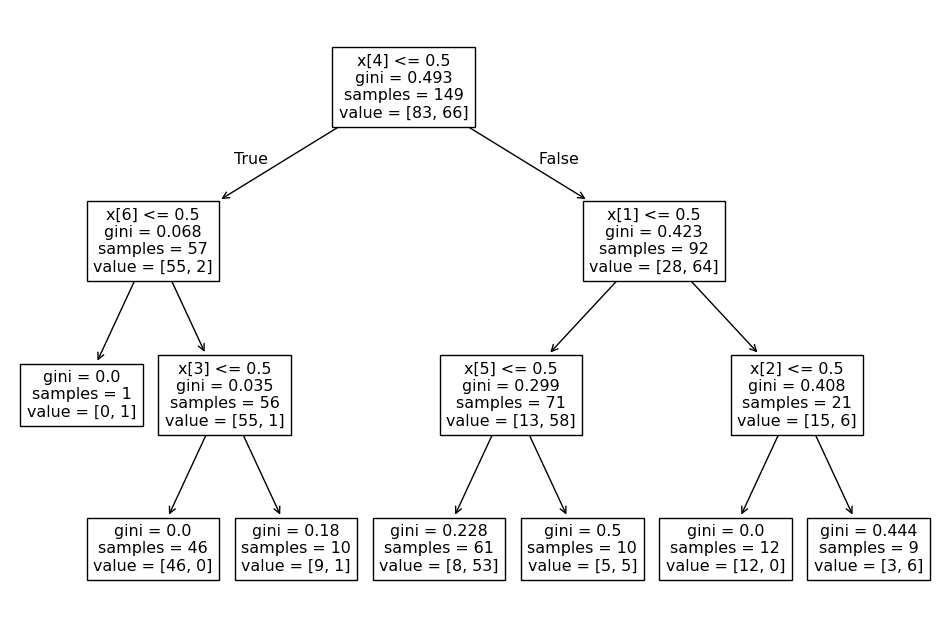

In [21]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(12,8))
tree.plot_tree(dtc.fit(X_train, y_train)) 